In [1]:
from utils import get_common_backbone_atoms, generate_df
from Bio import PDB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

c:\Users\HUAWEI\Desktop\materiale magistrale\CHL\CHL-Project\.venv\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


[05/31/24 16:18:50] WARNING  To use the Graphein submodule                                         embeddings.py:45
                             graphein.protein.features.sequence.embeddings, you need to install:                   
                             biovec                                                                                
                             To do so, use the following command: pip install biovec                               
                             Alternatively, you can install graphein with the extras:                              
                                                                                                                   
                             pip install graphein[extras]                                                          

[05/31/24 16:18:55] WARNING  To use the Graphein submodule graphein.protein.visualisation, you  visualisation.py:36
                             need to install: pytorch3d                                                            
                             pytorch3d cannot be installed via pip                                                 

                    WARNING  To use the Graphein submodule graphein.protein.meshes, you need to        meshes.py:30
                             install: pytorch3d                                                                    
                             To do so, use the following command: pip install pytorch3d                            

In [2]:

def get_rmsd(path_og, path_m):
    parser = PDB.PDBParser()
    structure_og = parser.get_structure("original", path_og)
    structure_m = parser.get_structure("mutation", path_m)
    atoms_og, atoms_m = get_common_backbone_atoms(structure_og, structure_m)
    superimposer = PDB.Superimposer()
    superimposer.set_atoms(atoms_og, atoms_m)
    superimposer.apply(structure_m.get_atoms())
    
    return superimposer.rms


df_paths = pd.read_csv('../datasets/df_with_scores.csv')



In [3]:
#strip df_paths columns names
df_paths.columns = df_paths.columns.str.strip()
df_paths.columns

Index(['Protein change allele 1', 'Protein change allele 2',
       'structure_allele1', 'structure_allele2', 'pdb_file_allele1',
       'pdb_file_allele2', 'patient', 'sex', 'birth', 'bmi',
       'physical_health_score', 'mental_health_score', 'AKUSSI_jointpain',
       'AKUSSI_spinalpain', 'KOOSpain', 'KOOSsymptoms', 'KOOSdaily_living',
       'KOOSsport', 'KOOS_QOL', 'HAQ_hapVAS', 'HAQ_haqDI', 'RMSD_A1',
       'RMSD_all_A1', 'Alignment_A1', 'RMSD_A2', 'RMSD_all_A2',
       'Alignment_A2'],
      dtype='object')

In [4]:
mutation_path_dict = {} 
for i, row in df_paths.iterrows():
    mutation_path_dict[row['Protein change allele 1']] = row['pdb_file_allele1']
    mutation_path_dict[row['Protein change allele 2']] = row['pdb_file_allele2']

print(len(mutation_path_dict))

45


In [5]:
print(mutation_path_dict)
path_mutation_dict = {v:k for k,v in mutation_path_dict.items()}

{'G161R': '../datasets/ALPHAFOLD PDBs/G161R_c8ba5/G161R_c8ba5_unrelaxed_rank_001_alphafold2_ptm_model_5_seed_000.pdb', 'His371Profs': '../datasets/ALPHAFOLD PDBs/H371fs_9b3dd/H371fs_9b3dd_unrelaxed_rank_001_alphafold2_ptm_model_3_seed_000.pdb', 'M368V': '../datasets/ALPHAFOLD PDBs/M368V_be390/M368V_be390_unrelaxed_rank_001_alphafold2_ptm_model_3_seed_000.pdb', 'S47L': '../datasets/ALPHAFOLD PDBs/S47L_9a618/S47L_9a618_unrelaxed_rank_001_alphafold2_ptm_model_5_seed_000.pdb', 'W97C': '../datasets/ALPHAFOLD PDBs/W97C_b9ccb/W97C_b9ccb_unrelaxed_rank_001_alphafold2_ptm_model_5_seed_000.pdb', 'S59fs': '../datasets/ALPHAFOLD PDBs/S59fs_cd7b7/S59fs_cd7b7_unrelaxed_rank_001_alphafold2_ptm_model_4_seed_000.pdb', 'D18N': '../datasets/ALPHAFOLD PDBs/D18N_1fe41/D18N_1fe41_unrelaxed_rank_001_alphafold2_ptm_model_5_seed_000.pdb', 'M339fs': '../datasets/ALPHAFOLD PDBs/M339fs_aa0f3/M339fs_aa0f3_unrelaxed_rank_001_alphafold2_ptm_model_4_seed_000.pdb', 'R225P': '../datasets/ALPHAFOLD PDBs/R225P_9ee52/R225

In [6]:
paths = list(mutation_path_dict.values())

In [7]:
# create a df with the pairs path, path 

from itertools import product

pairs = product(paths, paths)

In [8]:
from tqdm import tqdm

def generate_matriciona(paths):
    with tqdm(total=len(paths)*len(paths)) as pbar:
        M = np.zeros((len(paths), len(paths)))
        for i, path1 in enumerate(paths):
            for j, path2 in enumerate(paths):
                M[i, j] = get_rmsd(path1, path2)
                pbar.update(1)

    return M     

In [9]:
try:
    matriciona = np.load('../datasets/matriciona.npy')
except:
    print('generating matrix')
    matriciona = generate_matriciona(paths) 
    # the matriciona is symmetric, but due to numerical errors it is not exactly symmetric, we can fix this by averaging the matrix with its transpose
    print(np.linalg.norm(matriciona- matriciona.T))
    np.linalg.norm(matriciona- matriciona.T)
    matriciona = (matriciona + matriciona.T) /2
    print(np.linalg.norm(matriciona- matriciona.T))
    # also the diagonal is not zero, but it should be

    print(np.linalg.norm(np.diag(matriciona)))
    np.fill_diagonal(matriciona, 0)
    print(np.linalg.norm(np.diag(matriciona)))
    np.save('../datasets/matriciona.npy', matriciona)

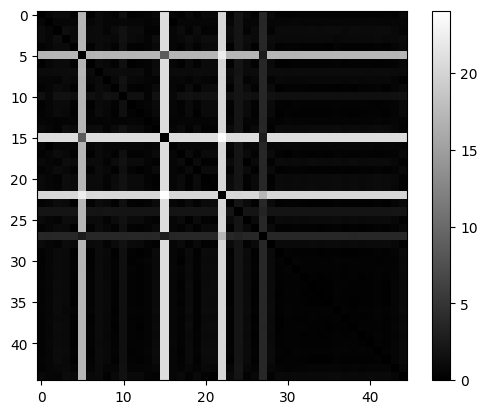

In [10]:
plt.imshow(matriciona, cmap='gray')
plt.colorbar()
plt.show()

In [11]:
# for each mutation, compute mean distance to all other mutations
mean_distances = matriciona.mean(axis=1)
std_distances = matriciona.std(axis=1)


In [12]:
# discard  the mutations with the highest mean distances
'''threshold = 4
matriciona = matriciona[mean_distances < threshold]
matriciona = matriciona[:, mean_distances < threshold]'''

'threshold = 4\nmatriciona = matriciona[mean_distances < threshold]\nmatriciona = matriciona[:, mean_distances < threshold]'

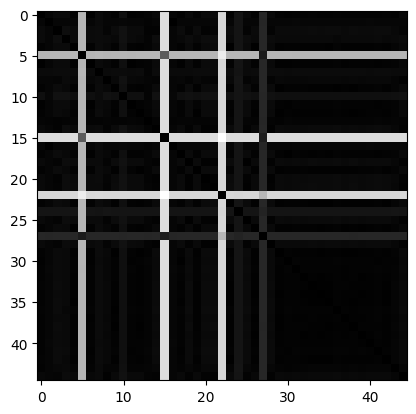

In [13]:
plt.imshow(matriciona, cmap='gray')

## K-medoids
We apply k-medoids algorithm to the protein structures.

In [14]:
from sklearn_extra.cluster import KMedoids



In [15]:
sse = []
for k in range(10):
    k_medoids = KMedoids(n_clusters=k+1, random_state=0, metric = 'precomputed').fit(matriciona) 
    sse.append(k_medoids.inertia_)
    print(k_medoids.inertia_)
    

80.28172216401242
75.69339230670637
74.864492771449
74.28076438958455
73.71122957008996
73.54766906347629
73.83841404943479
73.62346855941338
73.45844259060256
73.31839671721308


Text(0.5, 1.0, 'SSE vs Number of Clusters')

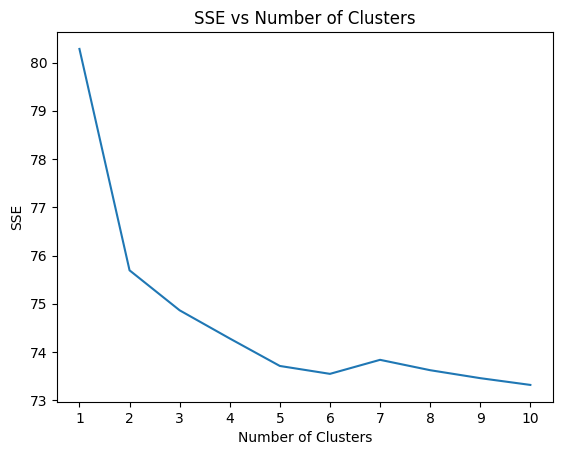

In [16]:
plt.plot( range(1,11), sse)
# set x ticks to be integers
plt.xticks(np.arange(1, 11, step=1))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("SSE vs Number of Clusters")


In [17]:
# refit with k=2

k_medoids = KMedoids(n_clusters=2, random_state=0, metric = 'precomputed').fit(matriciona)

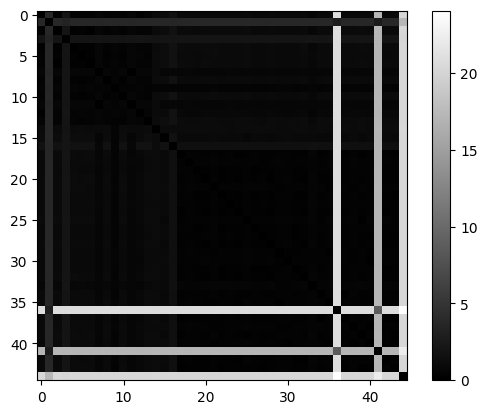

In [18]:
# order matrix by cluster
order = np.argsort(k_medoids.labels_)
clusters = k_medoids.labels_
clusters = clusters[order]
matriciona = matriciona[order, :]
matriciona = matriciona[:, order]
# colorbar
plt.imshow(matriciona, cmap='gray')
plt.colorbar()
plt.show()



<Axes: >

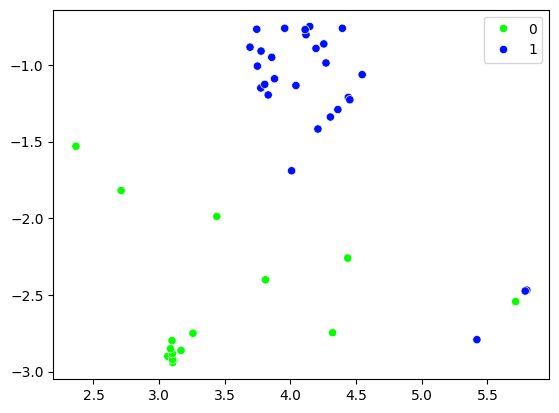

In [19]:
# t-SNE
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, random_state=0, metric='precomputed', init='random')
X_embedded = tsne.fit_transform(matriciona)

sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=clusters, palette=sns.color_palette("hsv", 2))
plt.title('t-SNE of the two clusters')
plt.show()


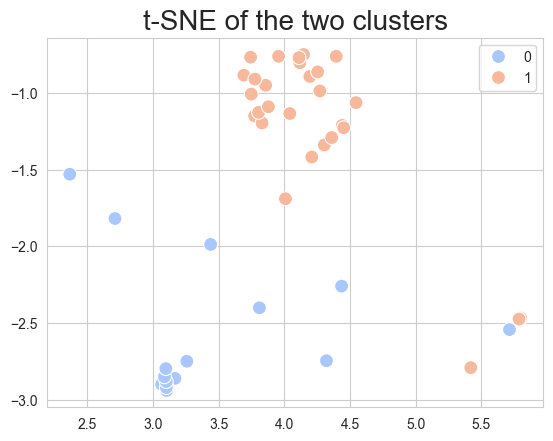

In [39]:
#plt.figure(figsize=(10, 8))  # Increase the size of the plot
sns.set_style("whitegrid")  # Add gridlines to the plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=clusters, palette="coolwarm", s=100)  # Increase the size of the points and use a different color palette
plt.title('t-SNE of the two clusters', fontsize=20)  # Increase the font size of the title
#plt.xlabel('Dimension 1', fontsize=16)  # Add label to the x-axis and increase the font size
#plt.ylabel('Dimension 2', fontsize=16)  # Add label to the y-axis and increase the font size
plt.show()

## Aggregation and statistics
Now we aggregate the scores by mutation, and see if there is any difference between mutations in the clusters.
From 2 clusters we pass to 3, patients with mutations in the same clusters and patients with two mutations in different clusters.

In [23]:
def get_cluster(mutation):
    path = mutation_path_dict[mutation]
    idx = paths.index(path)
    return k_medoids.labels_[idx]


df_paths['cluster1'] = df_paths['Protein change allele 1'].apply(get_cluster)
df_paths['cluster2'] = df_paths['Protein change allele 2'].apply(get_cluster)
df_paths['clusters'] = list(zip(df_paths['cluster1'], df_paths['cluster2']))

df_paths.drop(columns=['cluster1', 'cluster2'], inplace=True)
df_paths['clusters'] = df_paths['clusters'].apply(lambda x: str(set(x)))

In [24]:
# count the number of mutations in each cluster
df_paths['clusters'].value_counts()


{1}       58
{0}       23
{0, 1}    22
Name: clusters, dtype: int64

In [25]:
# mean of each metric for each cluster
mean_scores_clusters = df_paths.groupby('clusters').mean(numeric_only=True)


In [26]:

# std of each metric for each cluster
std_score_clusters = df_paths.groupby('clusters').std(numeric_only=True)


In [27]:
df_paths.columns    

Index(['Protein change allele 1', 'Protein change allele 2',
       'structure_allele1', 'structure_allele2', 'pdb_file_allele1',
       'pdb_file_allele2', 'patient', 'sex', 'birth', 'bmi',
       'physical_health_score', 'mental_health_score', 'AKUSSI_jointpain',
       'AKUSSI_spinalpain', 'KOOSpain', 'KOOSsymptoms', 'KOOSdaily_living',
       'KOOSsport', 'KOOS_QOL', 'HAQ_hapVAS', 'HAQ_haqDI', 'RMSD_A1',
       'RMSD_all_A1', 'Alignment_A1', 'RMSD_A2', 'RMSD_all_A2', 'Alignment_A2',
       'clusters'],
      dtype='object')

In [28]:
columns_to_test = ['birth', 'bmi',
       'physical_health_score', 'mental_health_score', 'AKUSSI_jointpain',
       'AKUSSI_spinalpain', 'KOOSpain', 'KOOSsymptoms', 'KOOSdaily_living',
       'KOOSsport', 'KOOS_QOL', 'HAQ_hapVAS', 'HAQ_haqDI']

for column in columns_to_test:
    cluster1 = df_paths[df_paths['clusters'] == '{0, 1}'][column]
    cluster2 = df_paths[df_paths['clusters'] == '{1}'][column]
    print(column, ttest_ind(cluster1, cluster2))

birth TtestResult(statistic=-2.375209509999903, pvalue=0.019995030517992594, df=78.0)
bmi TtestResult(statistic=-2.1219600071092666, pvalue=0.037015354621593485, df=78.0)
physical_health_score TtestResult(statistic=-1.4751218178681227, pvalue=0.1442050488759218, df=78.0)
mental_health_score TtestResult(statistic=0.24688464432338972, pvalue=0.8056461355362552, df=78.0)
AKUSSI_jointpain TtestResult(statistic=0.9412139412450494, pvalue=0.3495011467015233, df=78.0)
AKUSSI_spinalpain TtestResult(statistic=0.39871989680692616, pvalue=0.6911890465493584, df=78.0)
KOOSpain TtestResult(statistic=-1.1416332775904727, pvalue=0.25709919324776187, df=78.0)
KOOSsymptoms TtestResult(statistic=-0.5424779265276606, pvalue=0.5890359450282012, df=78.0)
KOOSdaily_living TtestResult(statistic=-1.3631657277909557, pvalue=0.17675238089131803, df=78.0)
KOOSsport TtestResult(statistic=-1.3531755513123196, pvalue=0.17990850840692296, df=78.0)
KOOS_QOL TtestResult(statistic=-1.444542841122688, pvalue=0.152591558

In [29]:
for column in columns_to_test:
    cluster1 = df_paths[df_paths['clusters'] == '{0}'][column]
    cluster2 = df_paths[df_paths['clusters'] == '{1}'][column]
    print(column, ttest_ind(cluster1, cluster2))

birth TtestResult(statistic=0.6162327263997012, pvalue=0.5395125636422967, df=79.0)
bmi TtestResult(statistic=-0.10201224380952015, pvalue=0.9190054433832485, df=79.0)
physical_health_score TtestResult(statistic=-0.6636295079210025, pvalue=0.5088595225325186, df=79.0)
mental_health_score TtestResult(statistic=1.9269195584635521, pvalue=0.05758527932293815, df=79.0)
AKUSSI_jointpain TtestResult(statistic=-0.9481791585131741, pvalue=0.34592976314030466, df=79.0)
AKUSSI_spinalpain TtestResult(statistic=-0.048559647004189584, pvalue=0.9613927864735733, df=79.0)
KOOSpain TtestResult(statistic=0.490149405713294, pvalue=0.6253867058312835, df=79.0)
KOOSsymptoms TtestResult(statistic=1.3923374163810471, pvalue=0.16772714178886977, df=79.0)
KOOSdaily_living TtestResult(statistic=0.24363578965513993, pvalue=0.808144472849384, df=79.0)
KOOSsport TtestResult(statistic=0.458259572161476, pvalue=0.6480240778787245, df=79.0)
KOOS_QOL TtestResult(statistic=1.2111939248526606, pvalue=0.2294318441576671

In [30]:
for column in columns_to_test:
    cluster1 = df_paths[df_paths['clusters'] == '{0, 1}'][column]
    cluster2 = df_paths[df_paths['clusters'] == '{0}'][column]
    print(column, ttest_ind(cluster1, cluster2))

birth TtestResult(statistic=-3.228121961751598, pvalue=0.002387224767621413, df=43.0)
bmi TtestResult(statistic=-1.9195923451447272, pvalue=0.06156028944283499, df=43.0)
physical_health_score TtestResult(statistic=-0.7906676384313891, pvalue=0.4334772754549864, df=43.0)
mental_health_score TtestResult(statistic=-1.3830901994417186, pvalue=0.1737771843671314, df=43.0)
AKUSSI_jointpain TtestResult(statistic=1.526831462586848, pvalue=0.13412577822686056, df=43.0)
AKUSSI_spinalpain TtestResult(statistic=0.39595864094657185, pvalue=0.6940934773854813, df=43.0)
KOOSpain TtestResult(statistic=-1.529407578243499, pvalue=0.13348734459019712, df=43.0)
KOOSsymptoms TtestResult(statistic=-1.6884654945859787, pvalue=0.0985625523159771, df=43.0)
KOOSdaily_living TtestResult(statistic=-1.5402288565480329, pvalue=0.13083207576300837, df=43.0)
KOOSsport TtestResult(statistic=-1.6444446494310032, pvalue=0.10737676893398457, df=43.0)
KOOS_QOL TtestResult(statistic=-2.626779622110217, pvalue=0.01189654178

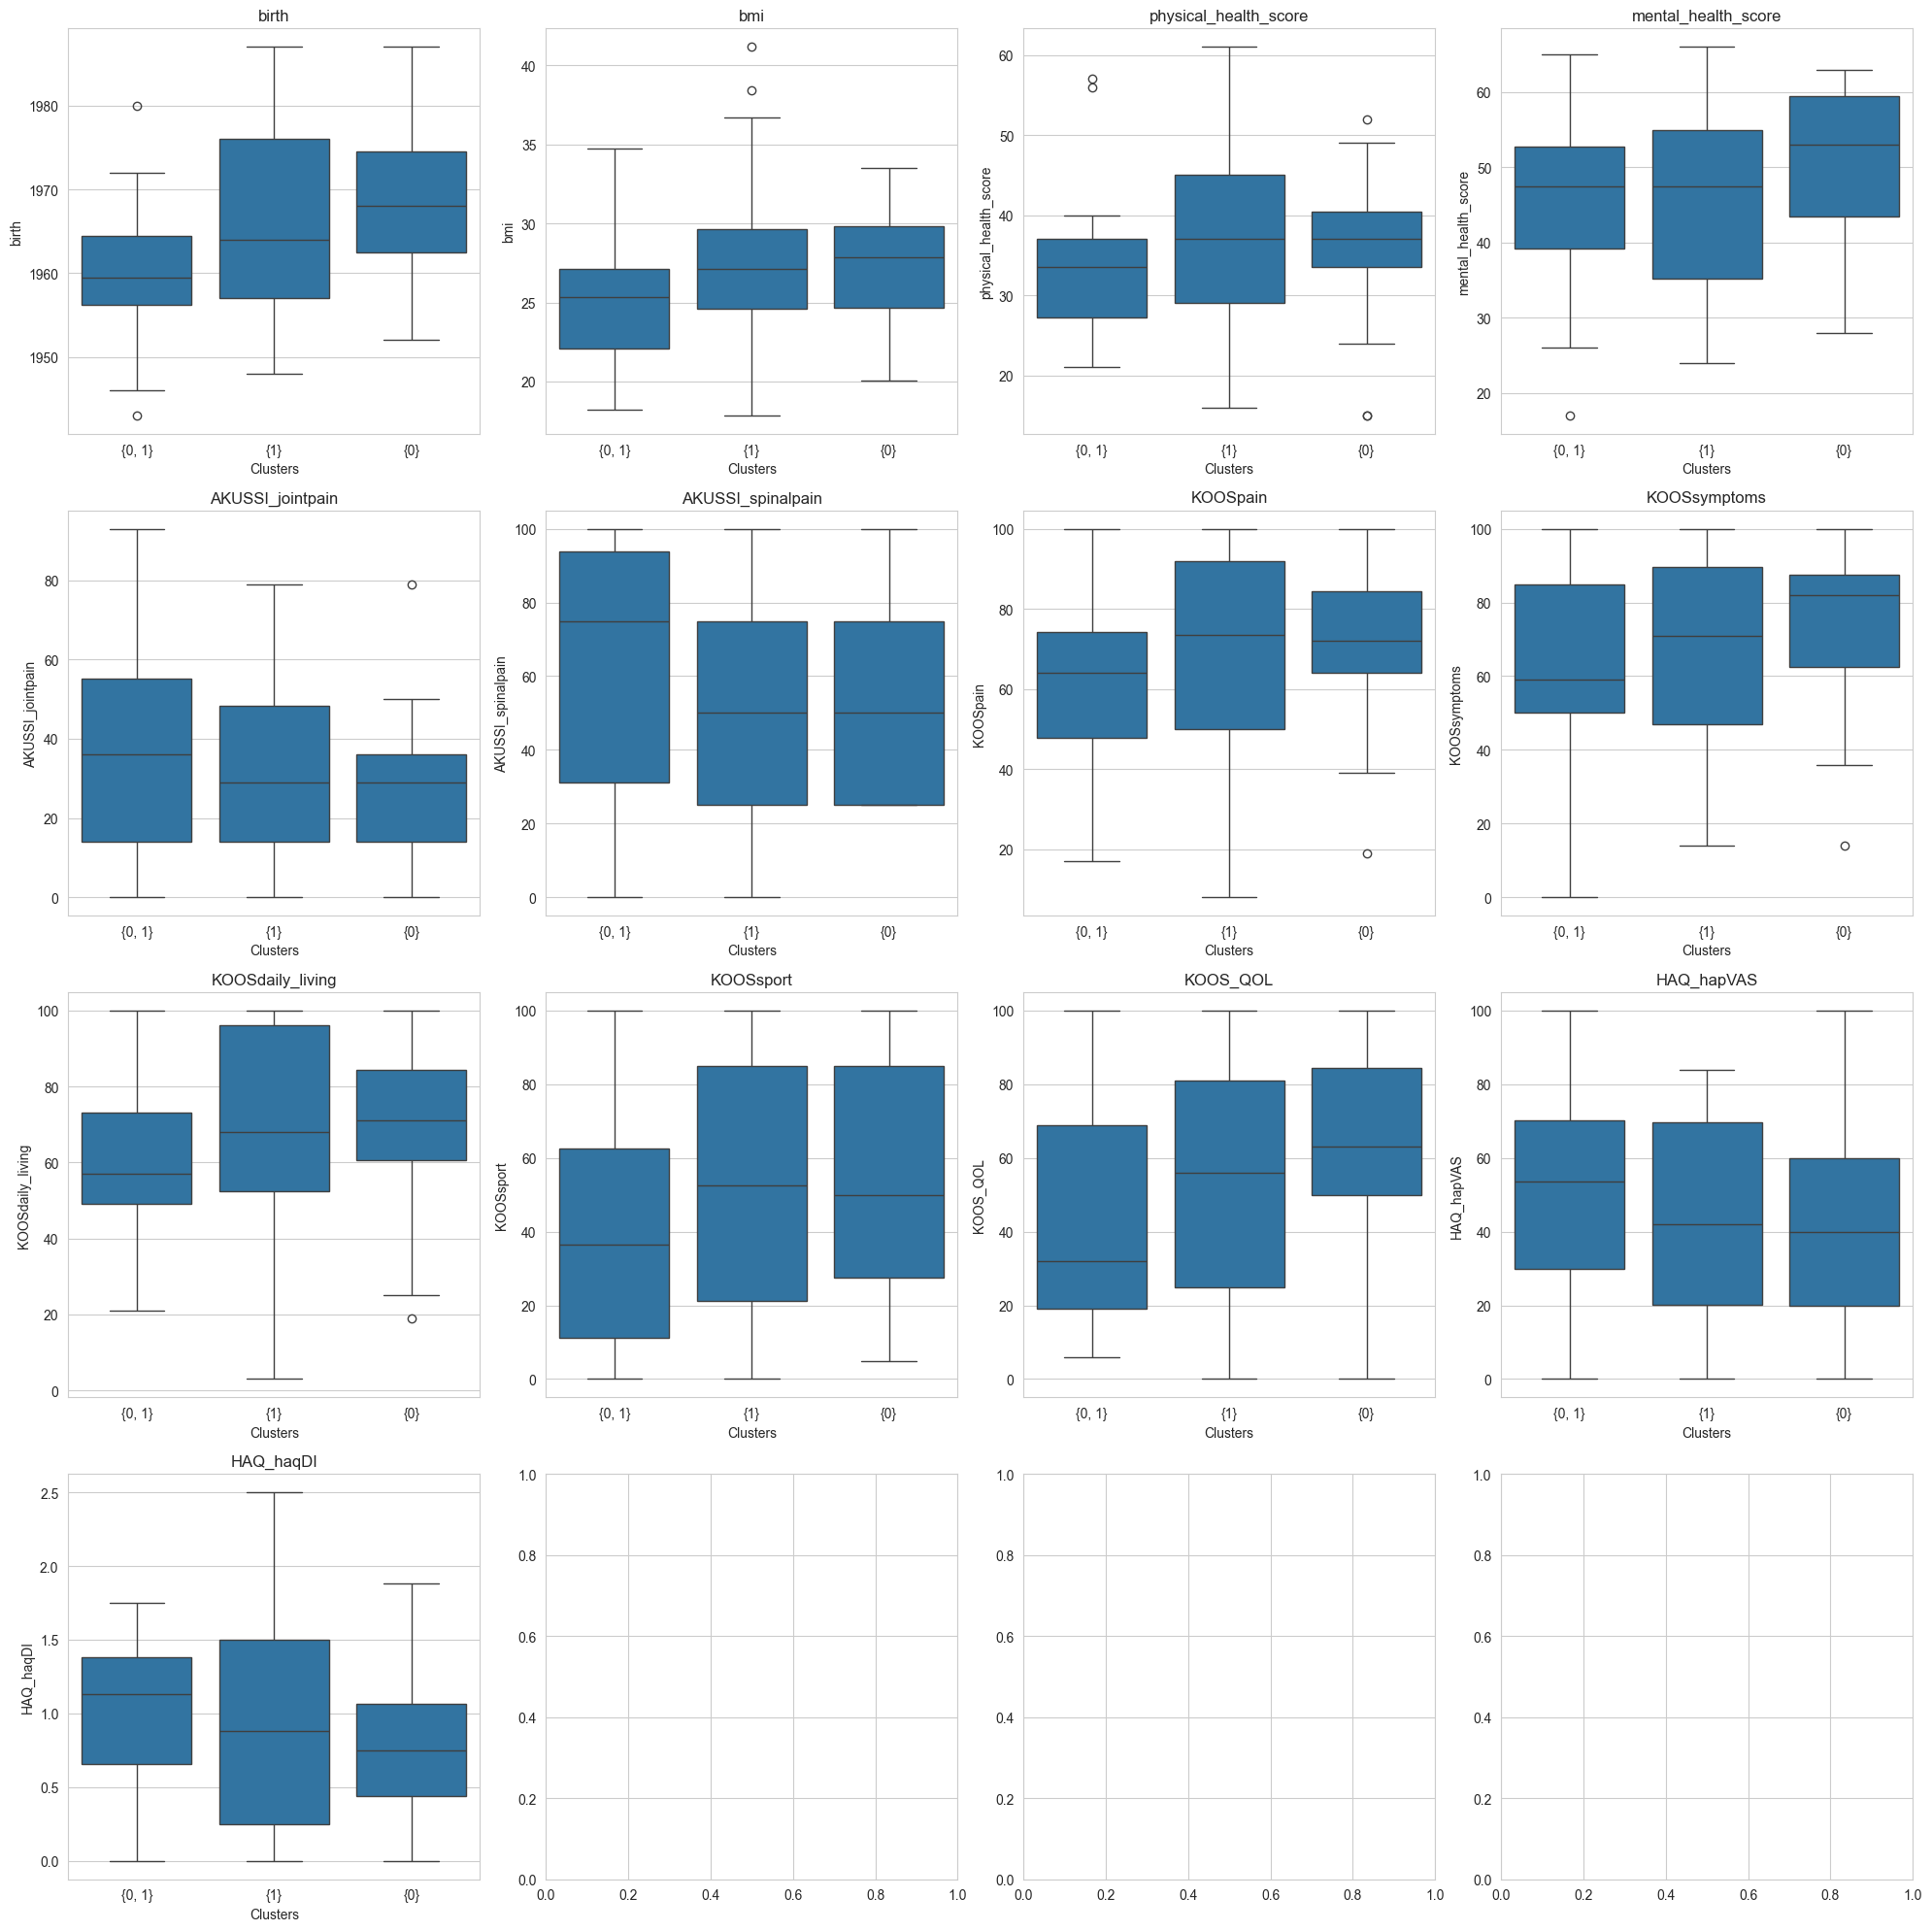

In [31]:
# plot values of each metric for each cluster
import seaborn as sns

fig, ax = plt.subplots(4, 4, figsize=(20, 20))

for i, column in enumerate(columns_to_test):
    sns.boxplot(x='clusters', y=column, data=df_paths, ax=ax[i//4, i%4])
    ax[i//4, i%4].set_title(column)
    ax[i//4, i%4].set_ylabel('')
    ax[i//4, i%4].set_xlabel('')
    ax[i//4, i%4].set_xlabel('Clusters')
    ax[i//4, i%4].set_ylabel(column)
    ax[i//4, i%4].set_title(column)
plt.tight_layout()
plt.show()
    

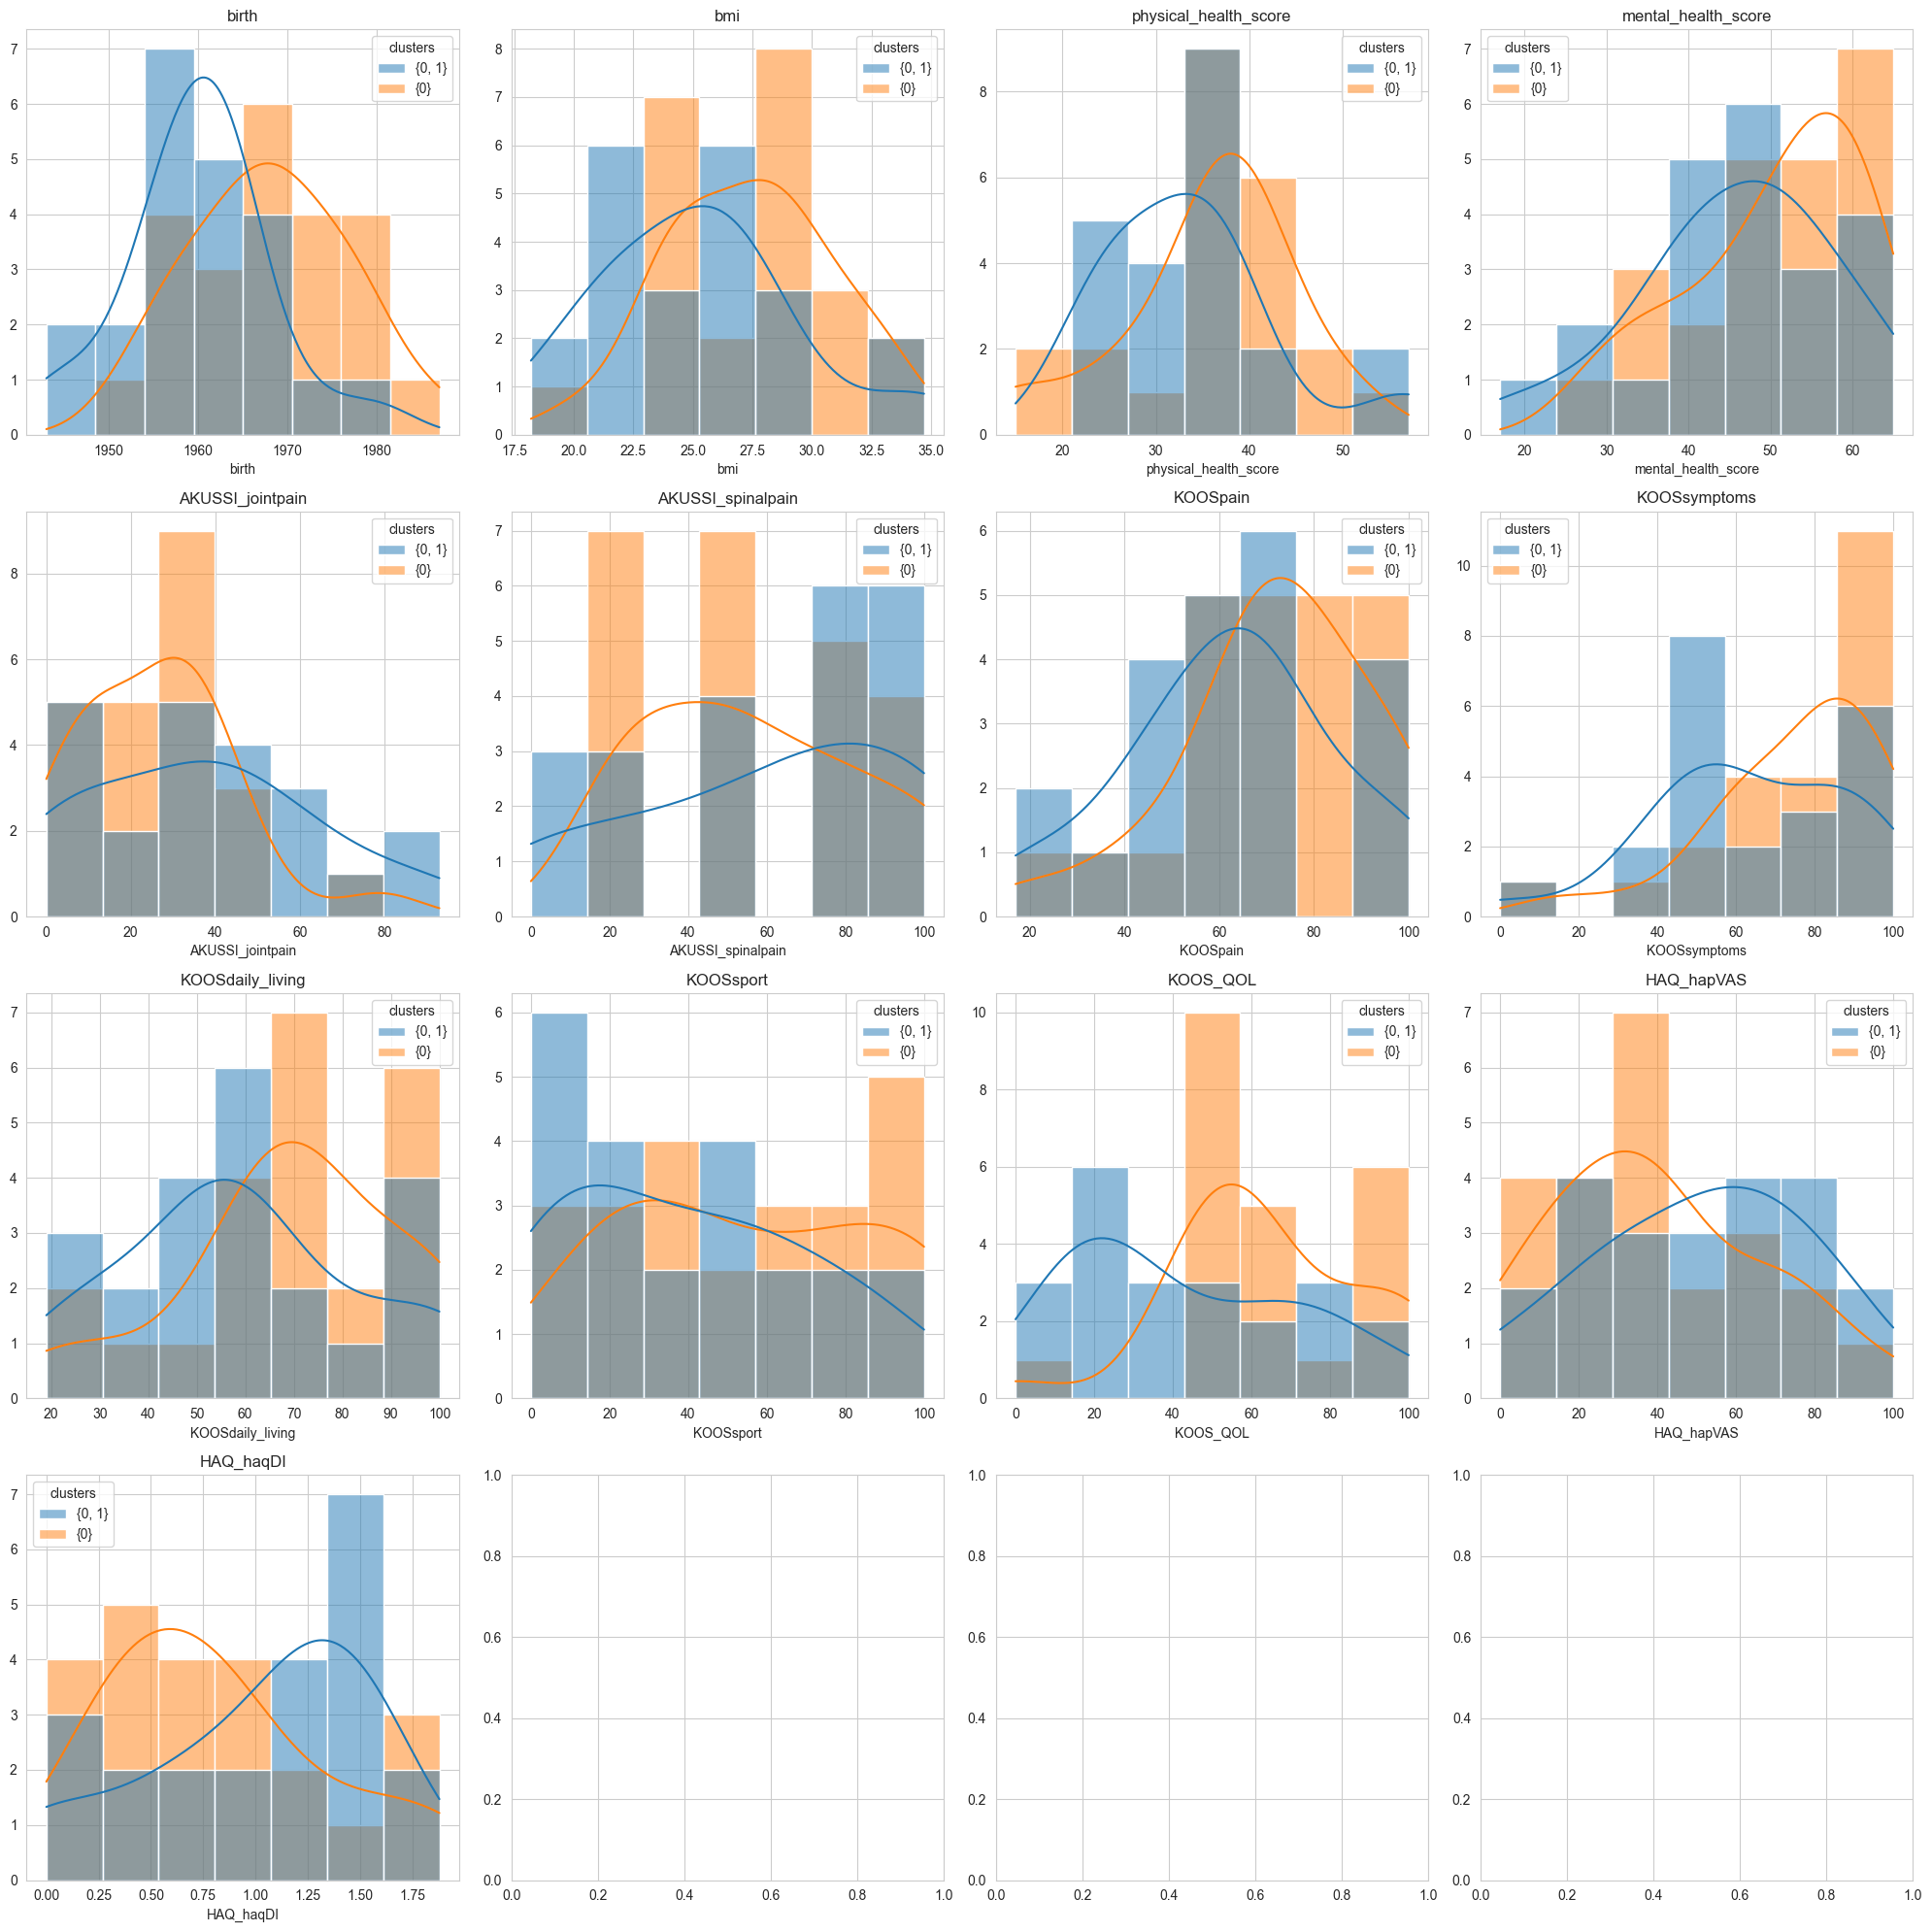

In [32]:
# plot distribution of each metric for each cluster

fig, ax = plt.subplots(4, 4, figsize=(20, 20))
df_paths_0 = df_paths[(df_paths['clusters'] == '{0}') | (df_paths['clusters'] == '{0, 1}')]

for i, column in enumerate(columns_to_test):
    sns.histplot(df_paths_0, x=column, hue='clusters', ax=ax[i//4, i%4], kde=True)
    ax[i//4, i%4].set_title(column)
    ax[i//4, i%4].set_ylabel('')
    ax[i//4, i%4].set_xlabel('')
    ax[i//4, i%4].set_xlabel(column)
    ax[i//4, i%4].set_title(column)
plt.tight_layout()
plt.show()

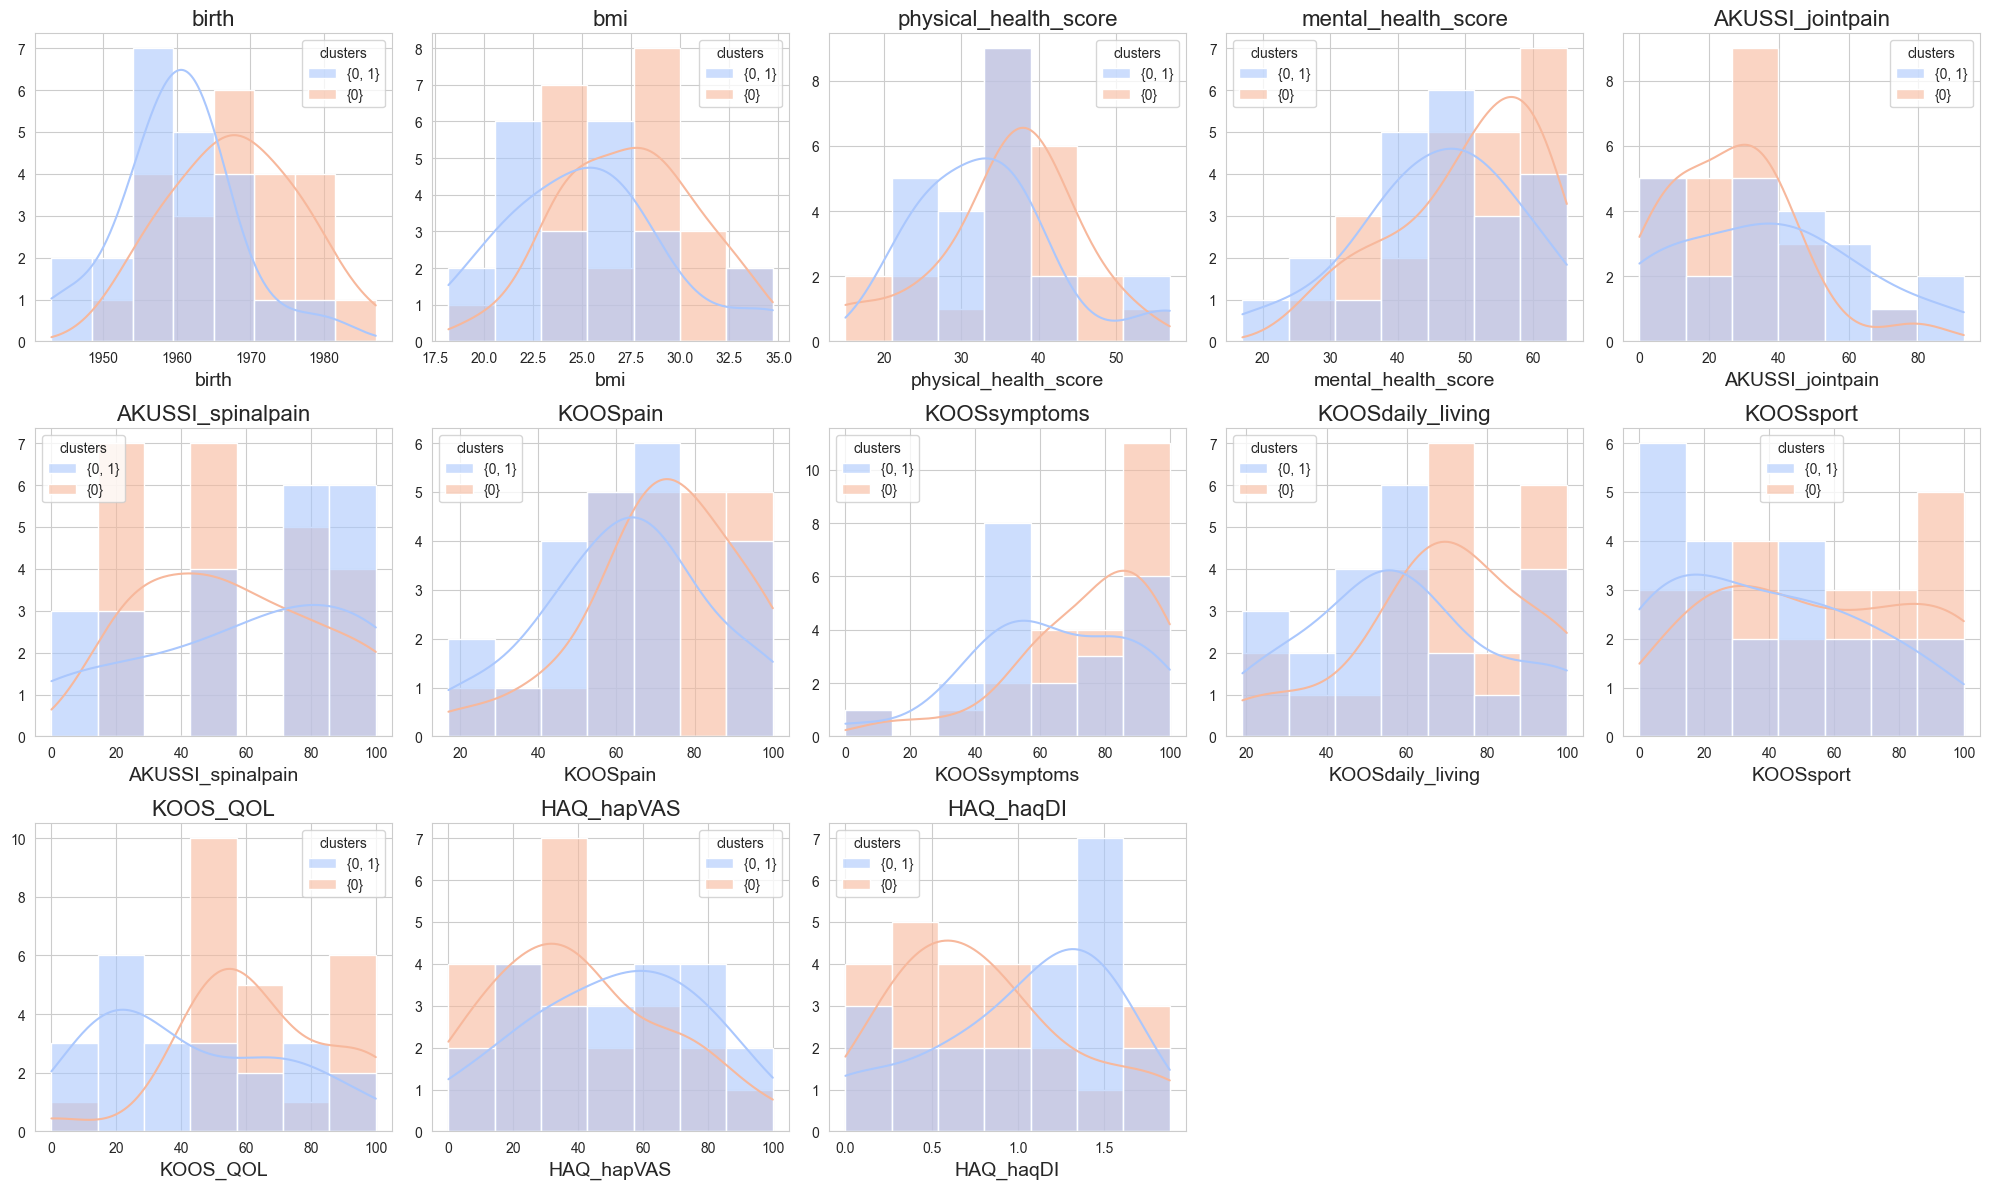

In [36]:
fig, ax = plt.subplots(3, 5, figsize=(20, 12))  # Create a grid of 3 rows and 5 columns
df_paths_0 = df_paths[(df_paths['clusters'] == '{0}') | (df_paths['clusters'] == '{0, 1}')]

for i, column in enumerate(columns_to_test):
    sns.histplot(df_paths_0, x=column, hue='clusters', ax=ax[i//5, i%5], kde=True, palette="coolwarm")  # Use a different color palette
    
    ax[i//5, i%5].set_title(column, fontsize=16)  # Add title to the plot and increase the font size
    ax[i//5, i%5].set_ylabel('')  # Remove the y-axis label as it's not necessary
    ax[i//5, i%5].set_xlabel(column, fontsize=14)  # Add label to the x-axis and increase the font size

# Remove the empty subplots
ax[2, 3].axis('off')
ax[2, 4].axis('off')

plt.tight_layout()
plt.show()

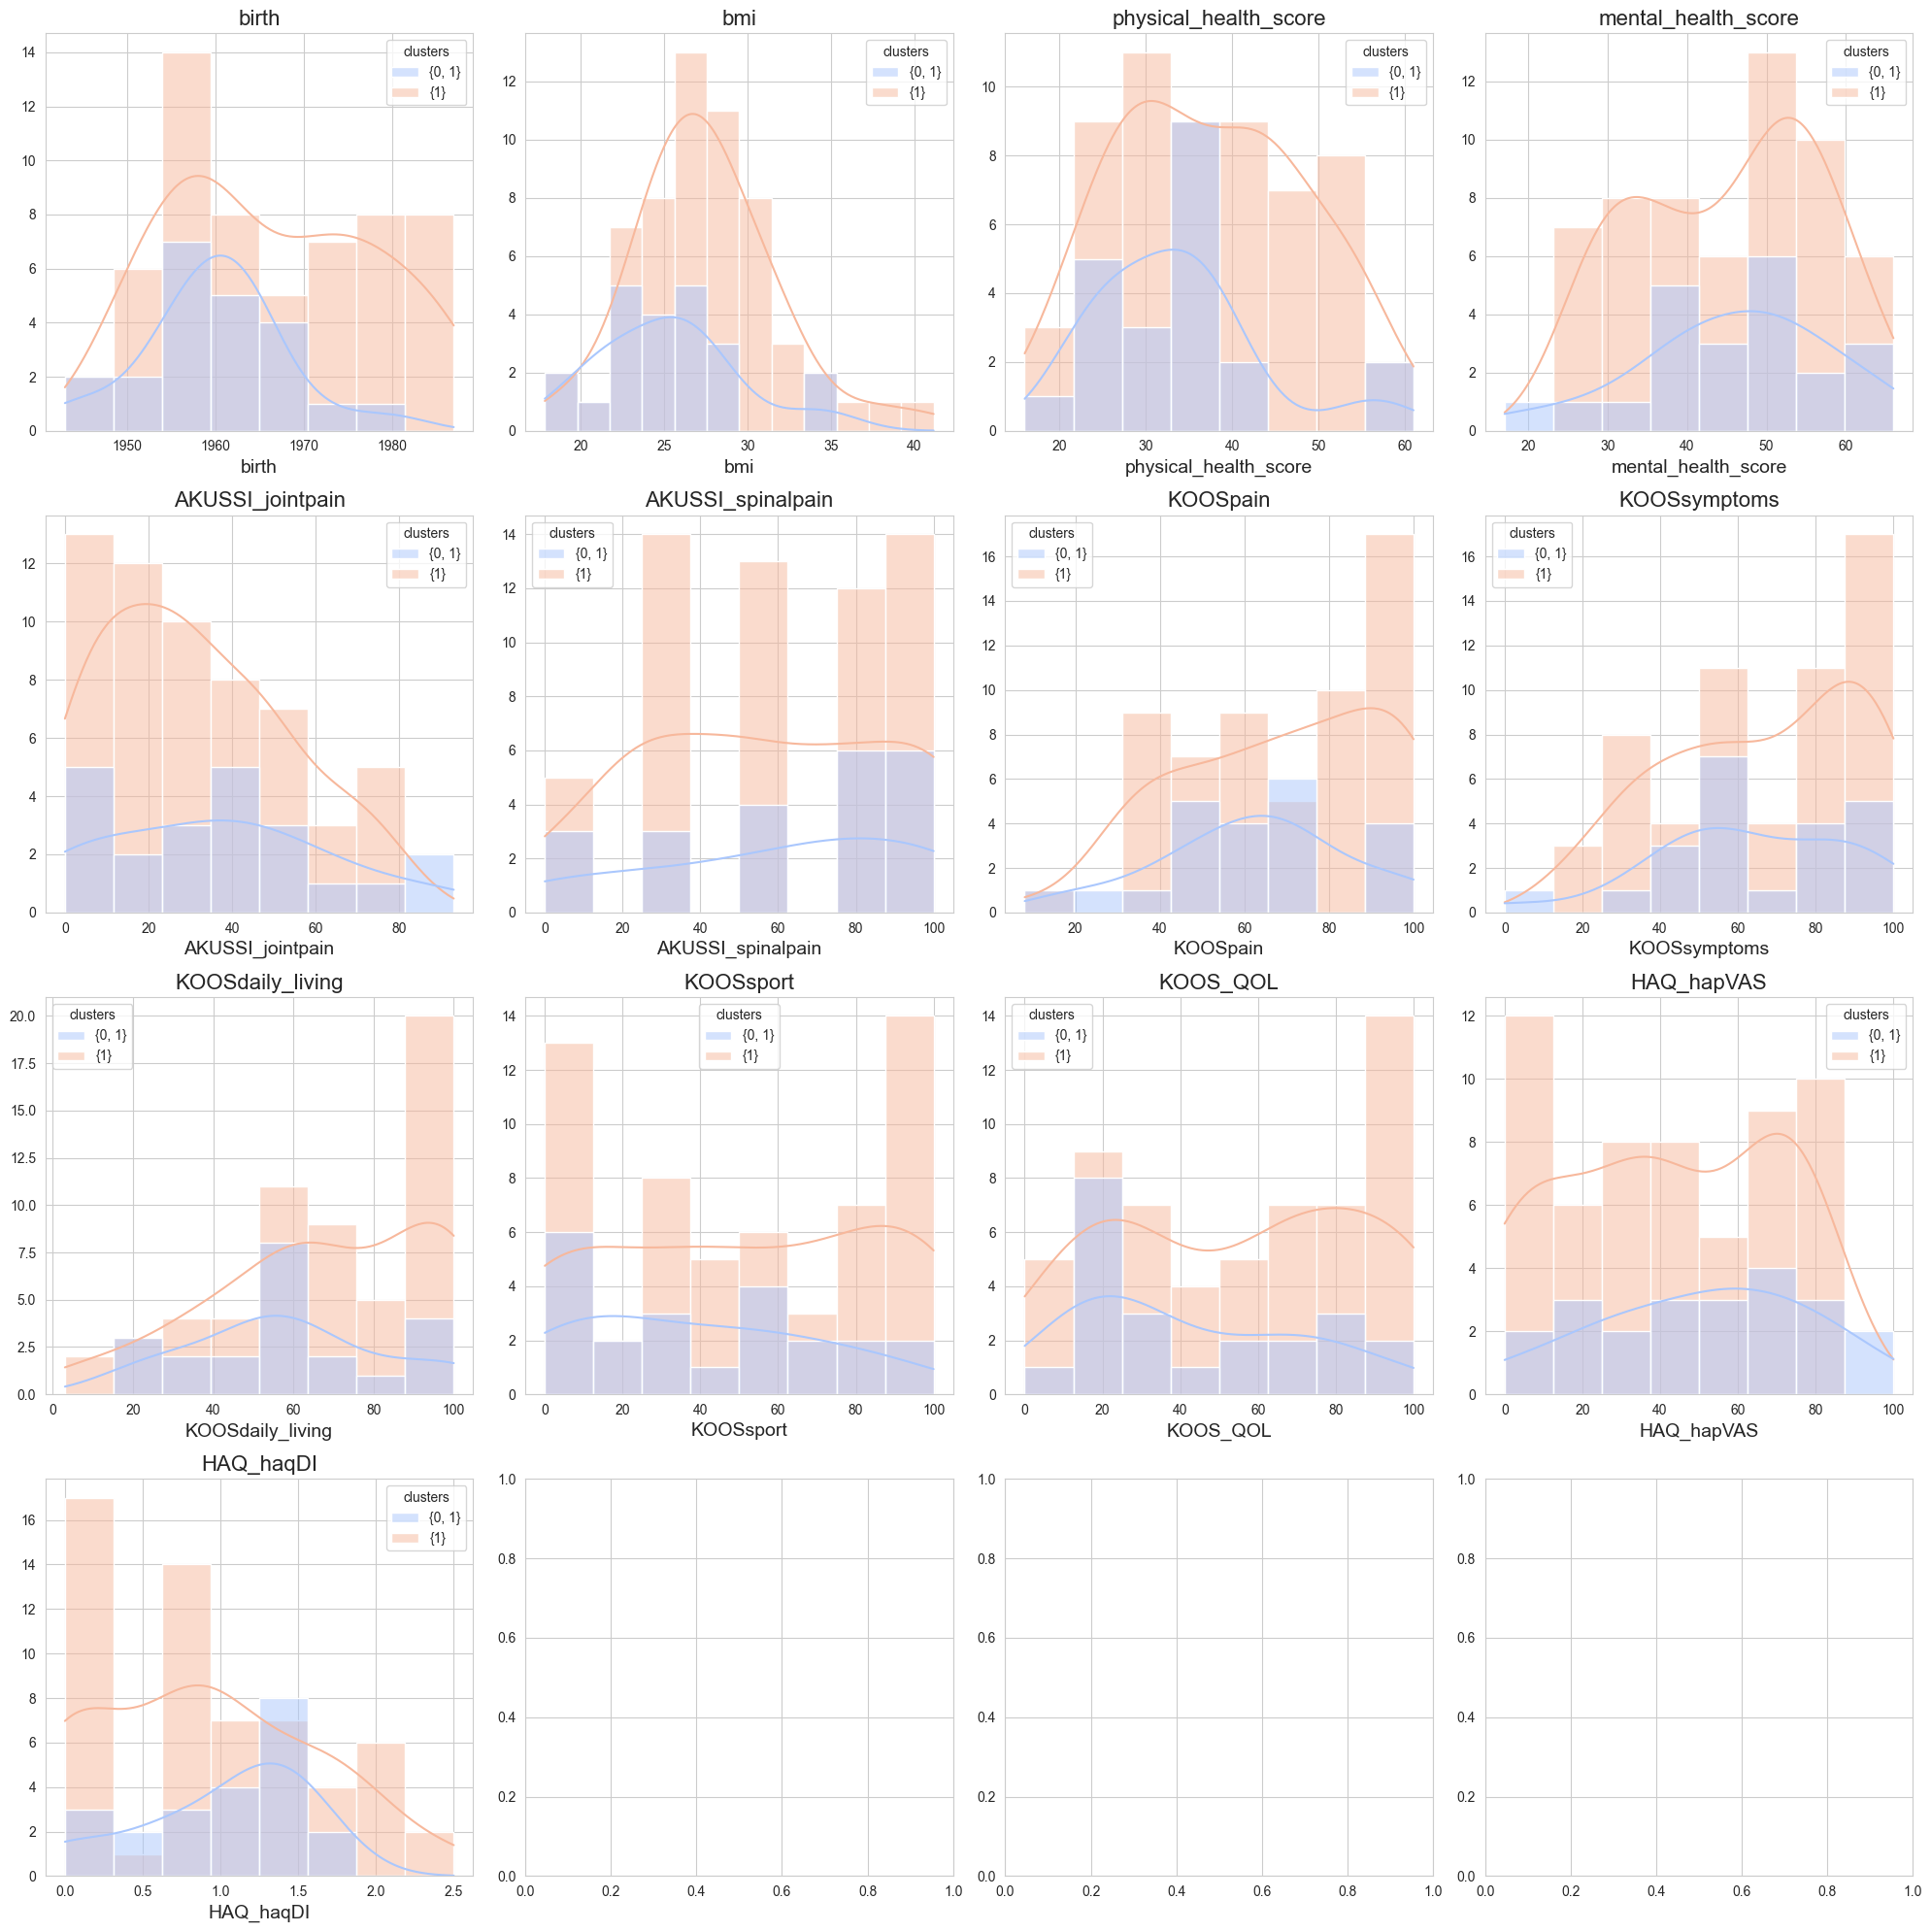

In [48]:
# plot distribution of each metric for each cluster

fig, ax = plt.subplots(4, 4, figsize=(20, 20))
df_paths_0 = df_paths[(df_paths['clusters'] == '{1}') | (df_paths['clusters'] == '{0, 1}')]

for i, column in enumerate(columns_to_test):
    sns.histplot(df_paths_0, x=column, hue='clusters', ax=ax[i//4, i%4], kde=True, palette="coolwarm")  # Use a different color palette
    ax[i//4, i%4].set_title(column, fontsize=16)  # Add title to the plot and increase the font size
    ax[i//4, i%4].set_ylabel('')  # Remove the y-axis label as it's not necessary
    ax[i//4, i%4].set_xlabel(column, fontsize=14)  # Add label to the x-axis and increase the font size
plt.tight_layout()
plt.show()

In [40]:
for column in columns_to_test:
    cluster1 = df_paths[(df_paths['clusters'] == '{0, 1}') | (df_paths['clusters']=='{0}')][column]
    cluster2 = df_paths[df_paths['clusters'] == '{1}'][column]
    print(column, ttest_ind(cluster1, cluster2))

birth TtestResult(statistic=-1.0782014399551474, pvalue=0.283512221767271, df=101.0)
bmi TtestResult(statistic=-1.4130761530989946, pvalue=0.16070774014119307, df=101.0)
physical_health_score TtestResult(statistic=-1.3681652846637034, pvalue=0.17429641820744785, df=101.0)
mental_health_score TtestResult(statistic=1.3556535901341176, pvalue=0.1782330206669121, df=101.0)
AKUSSI_jointpain TtestResult(statistic=0.04311491819733601, pvalue=0.965695049790844, df=101.0)
AKUSSI_spinalpain TtestResult(statistic=0.22594409780467878, pvalue=0.8217014965684598, df=101.0)
KOOSpain TtestResult(statistic=-0.41084580583948327, pvalue=0.6820559623734938, df=101.0)
KOOSsymptoms TtestResult(statistic=0.5276440269057029, pvalue=0.5989036744868486, df=101.0)
KOOSdaily_living TtestResult(statistic=-0.7095018379200221, pvalue=0.4796478419993897, df=101.0)
KOOSsport TtestResult(statistic=-0.5418441474969562, pvalue=0.5891192604416369, df=101.0)
KOOS_QOL TtestResult(statistic=-0.1523671013962716, pvalue=0.8792

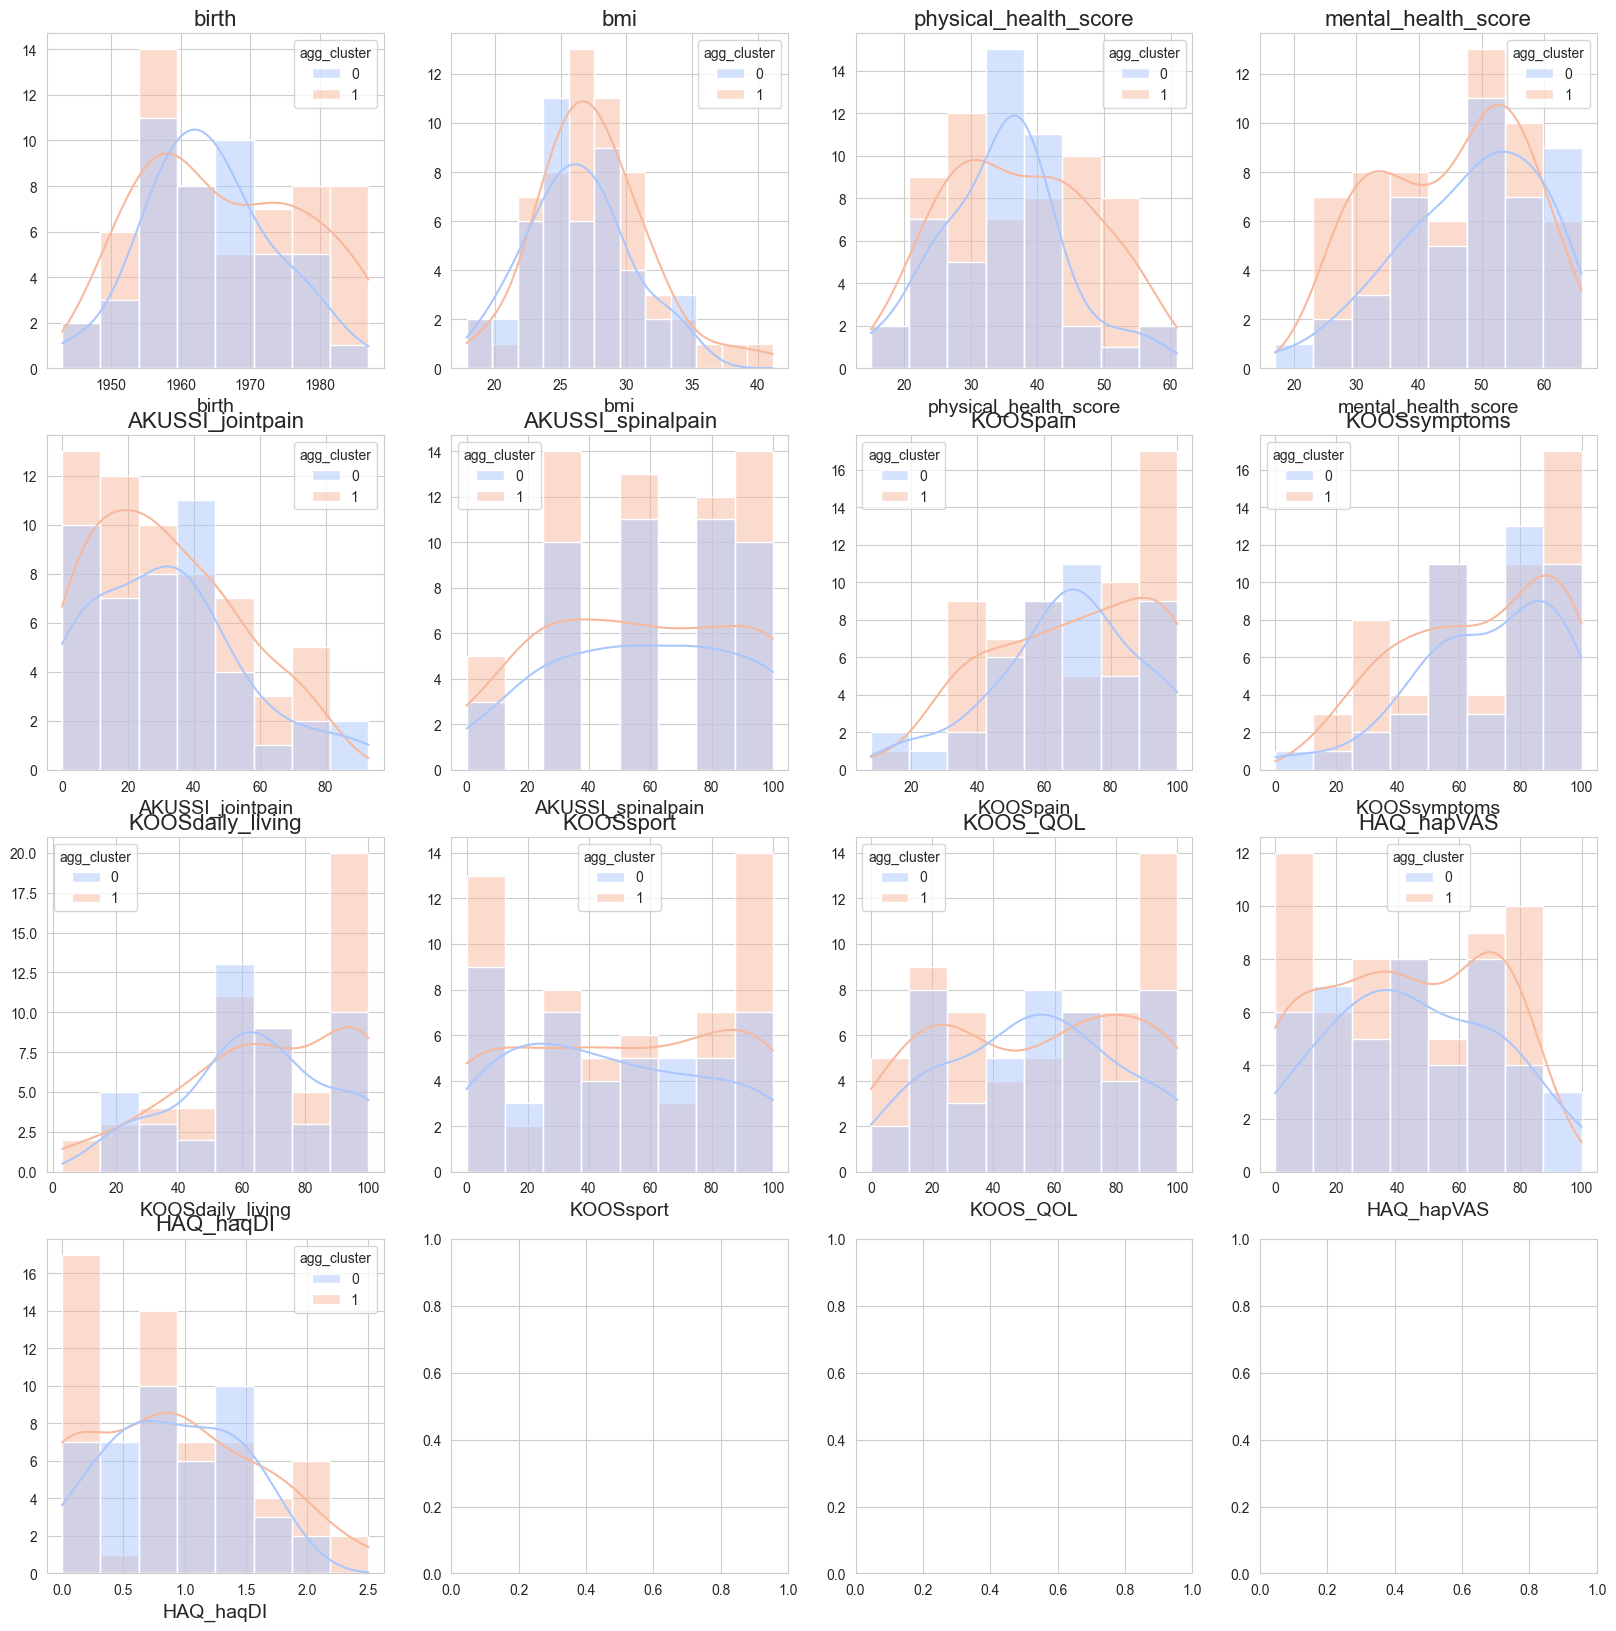

In [47]:
df_paths['agg_cluster'] = df_paths['clusters'].apply(lambda x: 0 if '0' in x else 1)

fig, ax = plt.subplots(4, 4, figsize=(20, 20))  

for i, column in enumerate(columns_to_test):
    sns.histplot(df_paths, x=column, hue='agg_cluster', ax=ax[i//4, i%4], kde=True, palette="coolwarm")  # Use a different color palette
    ax[i//4, i%4].set_title(column, fontsize=16)  # Add title to the plot and increase the font size
    ax[i//4, i%4].set_ylabel('')  # Remove the y-axis label as it's not necessary
    ax[i//4, i%4].set_xlabel(column, fontsize=14)  # Add label to the x-axis and increase the font size
    

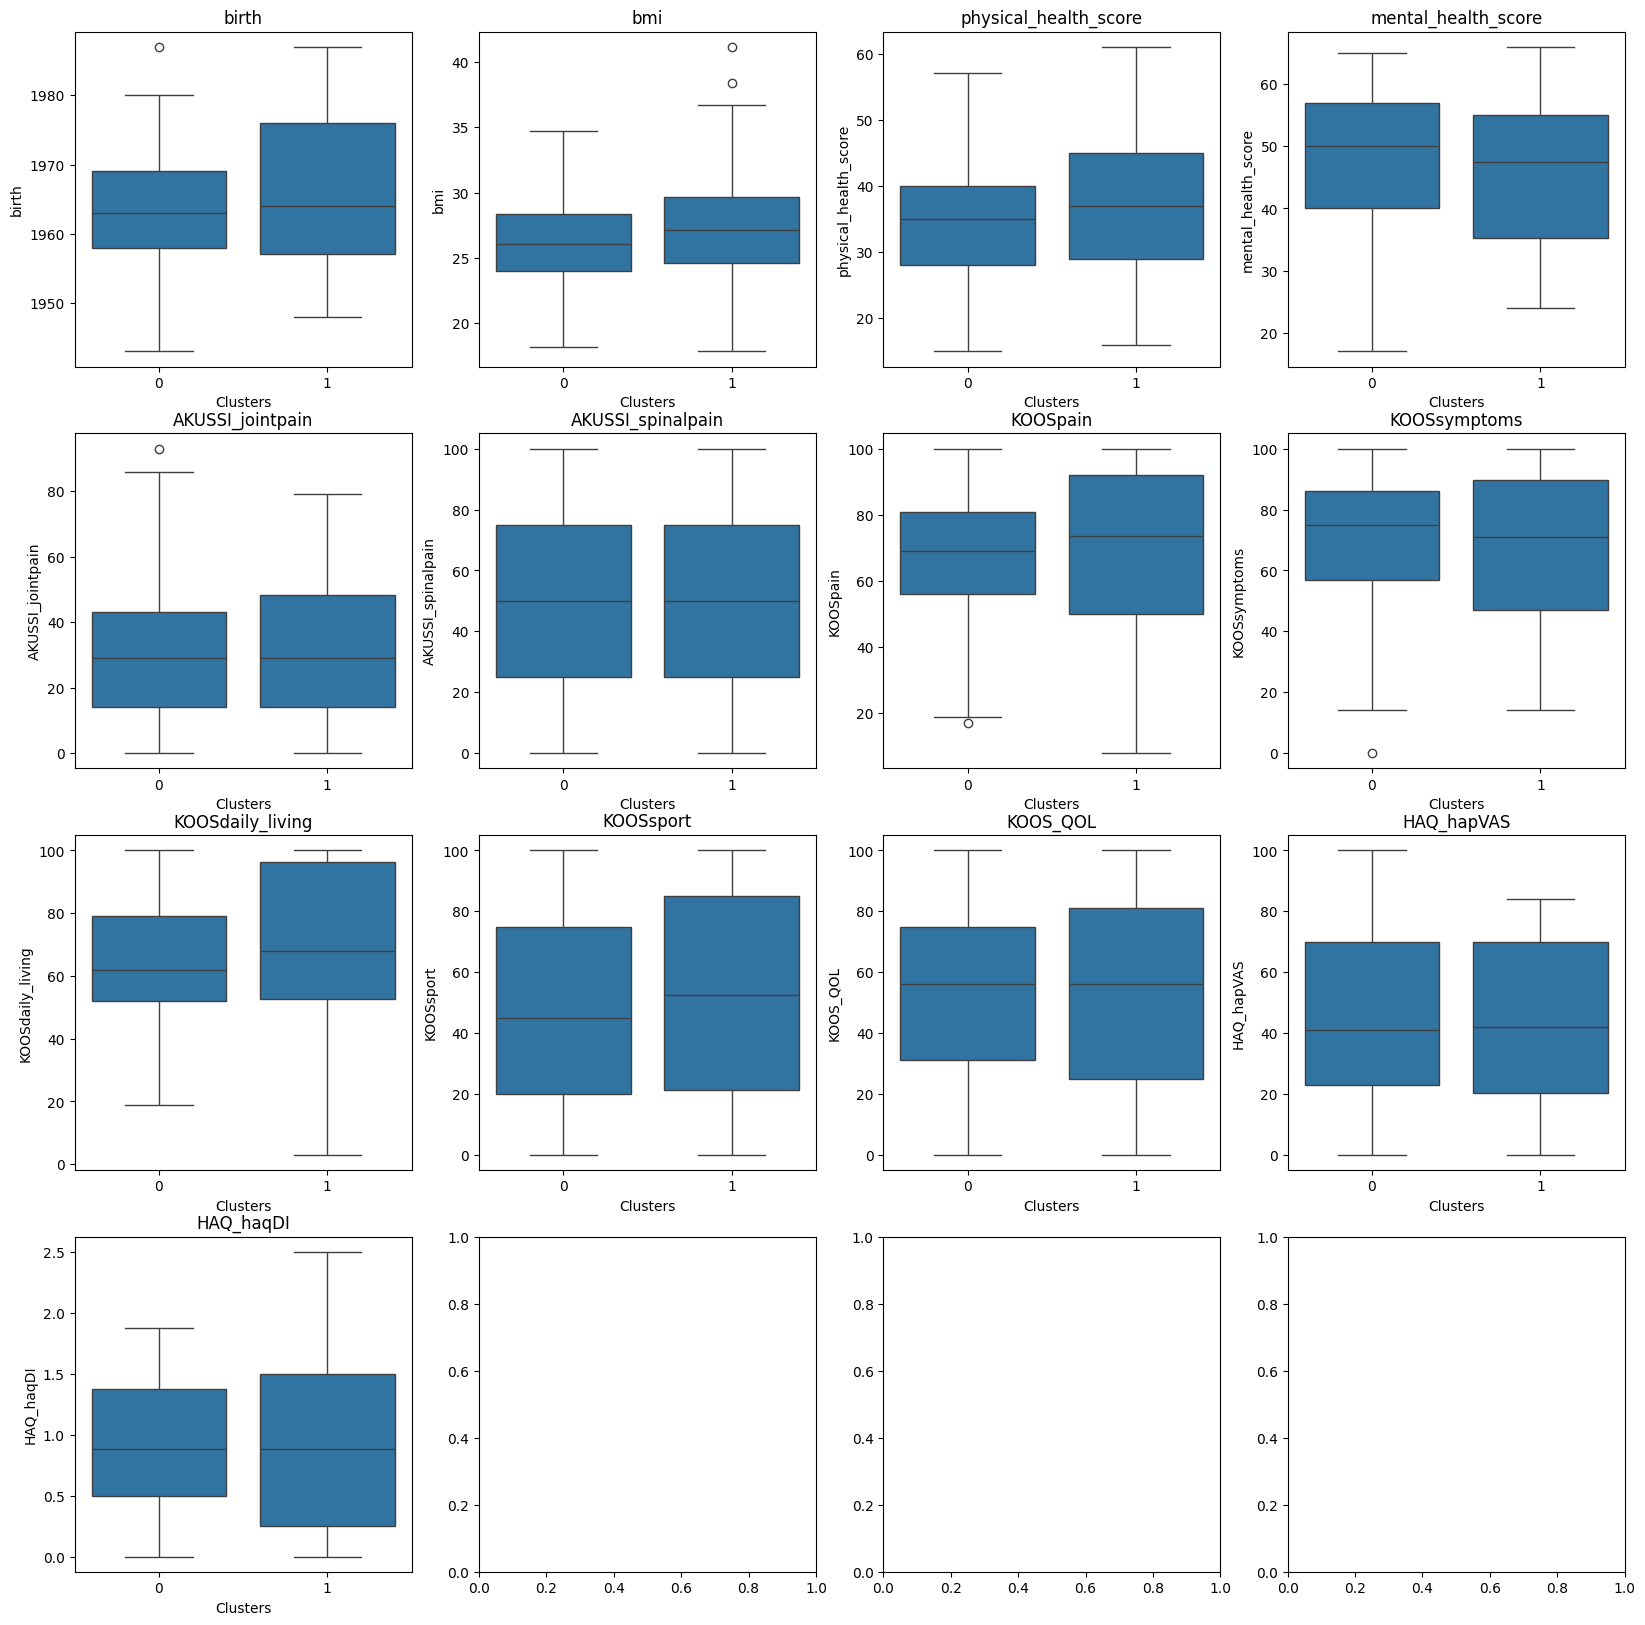

In [391]:
# plot values of each metric for each cluster with 2 clusters
import seaborn as sns

clusters = df_paths['clusters'].apply(lambda x: x[1:-1].split(', '))
df_paths['cluster1'] = clusters.apply(lambda x: int(x[0]))

fig, ax = plt.subplots(4, 4, figsize=(20, 20))

for i, column in enumerate(columns_to_test):
    sns.boxplot(x='cluster1', y=column, data=df_paths, ax=ax[i//4, i%4])
    ax[i//4, i%4].set_title(column)
    ax[i//4, i%4].set_ylabel('')
    ax[i//4, i%4].set_xlabel('')
    ax[i//4, i%4].set_xlabel('Clusters')
    ax[i//4, i%4].set_ylabel(column)
    ax[i//4, i%4].set_title(column)

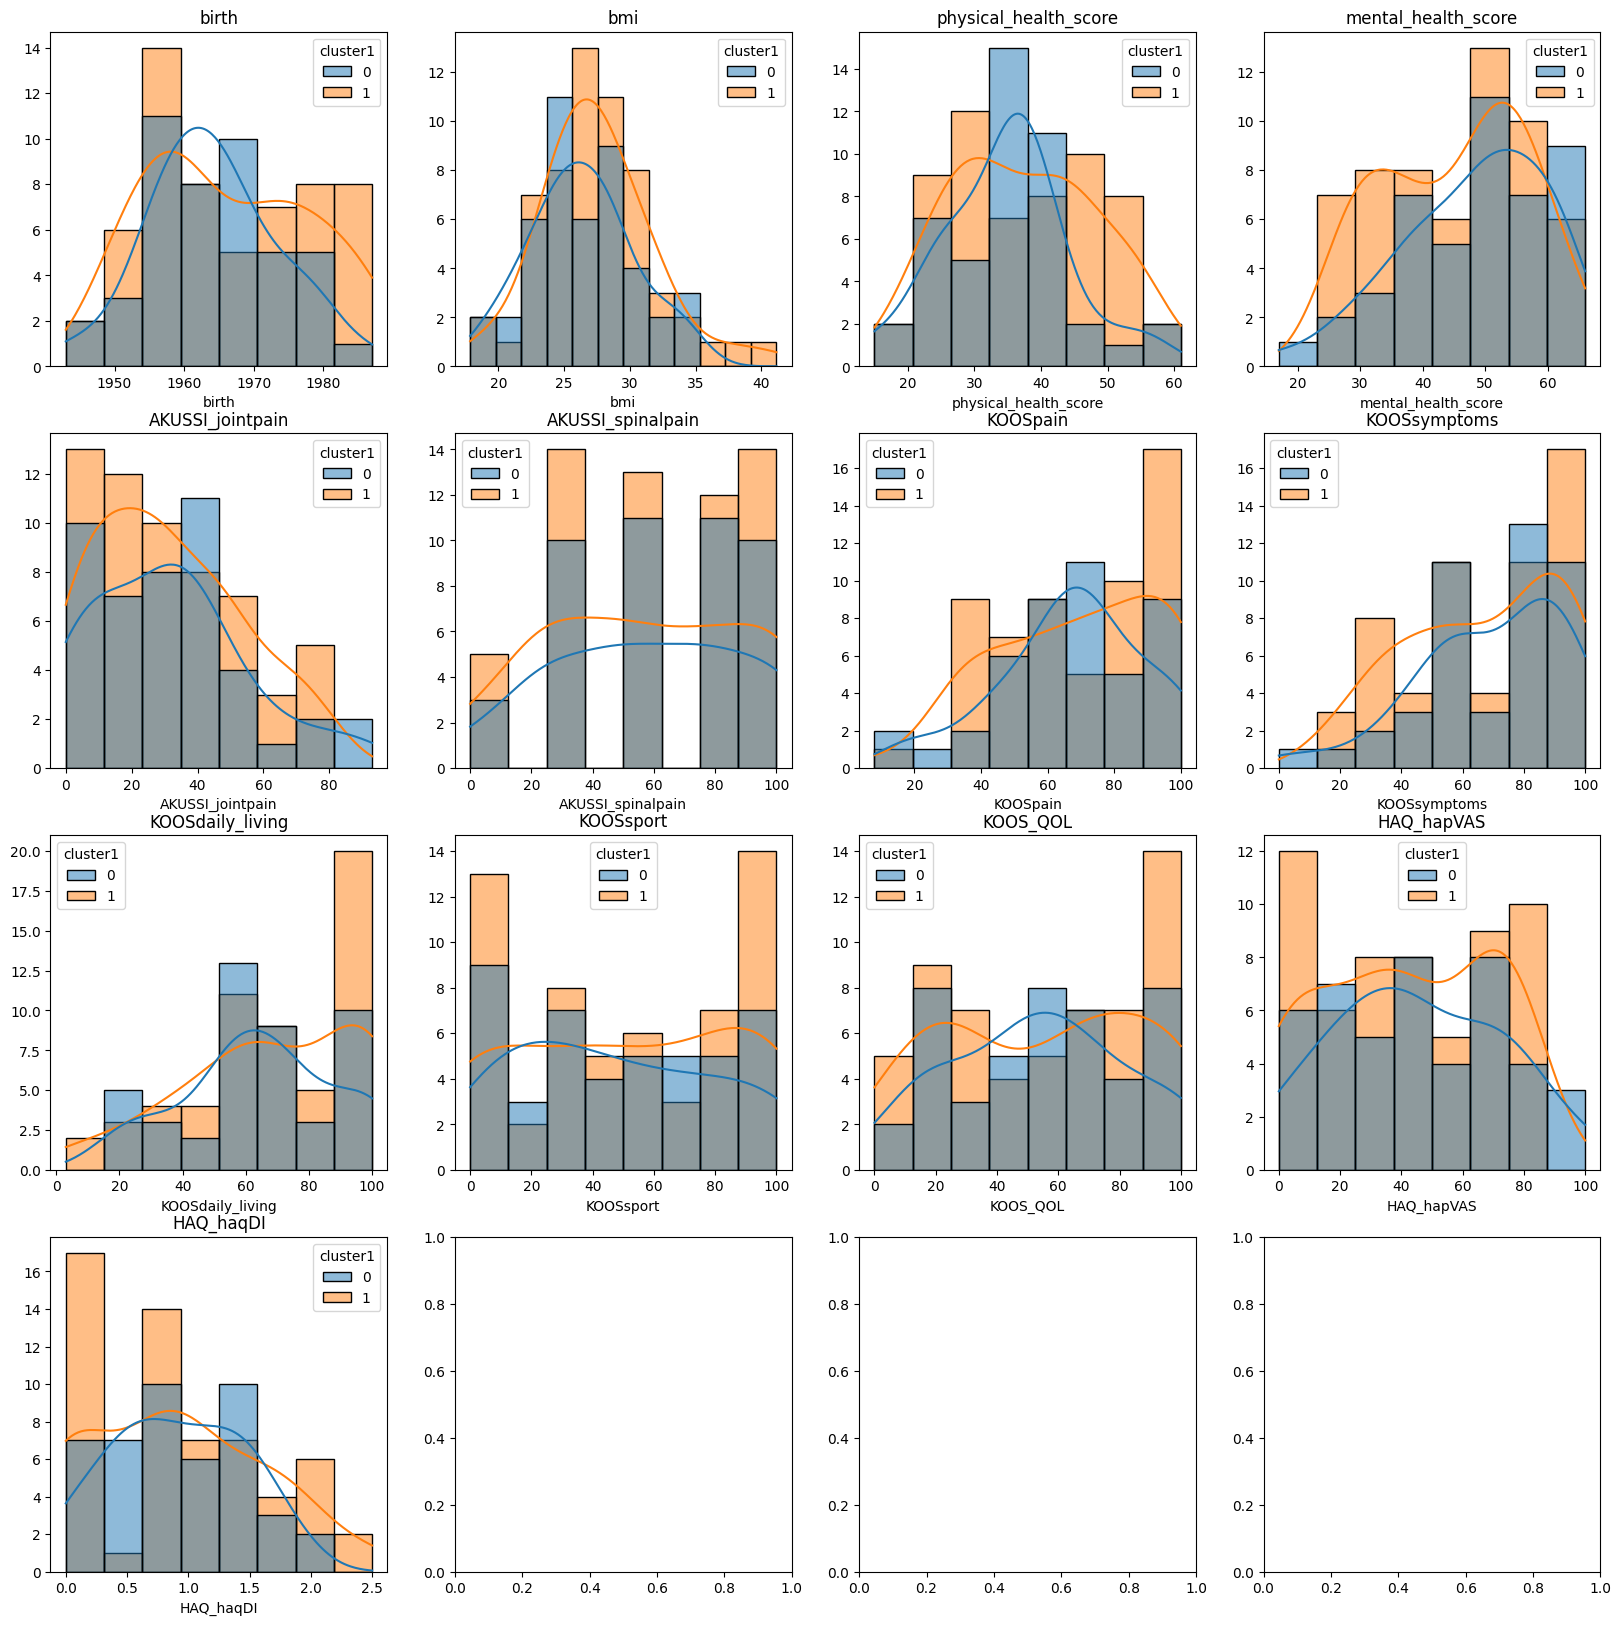

In [392]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))

for i, column in enumerate(columns_to_test):
    sns.histplot(df_paths, x=column, hue='cluster1', ax=ax[i//4, i%4], kde=True)
    ax[i//4, i%4].set_title(column)
    ax[i//4, i%4].set_ylabel('')
    ax[i//4, i%4].set_xlabel('')
    ax[i//4, i%4].set_xlabel(column)
    ax[i//4, i%4].set_title(column)

In [393]:
df = pd.read_excel('../datasets/aku_prin_v2.0.xlsx')

# strip column names

df.columns = df.columns.str.strip()
df_paths.columns = df_paths.columns.str.strip()
df_paths.columns

Index(['Protein change allele 1', 'Protein change allele 2',
       'structure_allele1', 'structure_allele2', 'pdb_file_allele1',
       'pdb_file_allele2', 'patient', 'sex', 'birth', 'bmi',
       'physical_health_score', 'mental_health_score', 'AKUSSI_jointpain',
       'AKUSSI_spinalpain', 'KOOSpain', 'KOOSsymptoms', 'KOOSdaily_living',
       'KOOSsport', 'KOOS_QOL', 'HAQ_hapVAS', 'HAQ_haqDI', 'RMSD_A1',
       'RMSD_all_A1', 'Alignment_A1', 'RMSD_A2', 'RMSD_all_A2', 'Alignment_A2',
       'clusters', 'cluster1'],
      dtype='object')

In [394]:
for col in df.columns:
    # if column is in df_paths
    if col in df_paths.columns and col !='patient':
        # drop from df_complete
        print(col)
        df.drop(columns=[col], inplace=True)
        

sex
birth
Protein change allele 1
Protein change allele 2
bmi
physical_health_score
mental_health_score
AKUSSI_jointpain
AKUSSI_spinalpain
KOOSpain
KOOSsymptoms
KOOSdaily_living
KOOSsport
KOOS_QOL
HAQ_hapVAS
HAQ_haqDI


In [395]:
df_complete = df_paths.merge(df, on='patient', how='inner')
# remove duplicate columns


In [396]:
df_complete.shape

(103, 79)

In [397]:
df_complete.columns 

Index(['Protein change allele 1', 'Protein change allele 2',
       'structure_allele1', 'structure_allele2', 'pdb_file_allele1',
       'pdb_file_allele2', 'patient', 'sex', 'birth', 'bmi',
       'physical_health_score', 'mental_health_score', 'AKUSSI_jointpain',
       'AKUSSI_spinalpain', 'KOOSpain', 'KOOSsymptoms', 'KOOSdaily_living',
       'KOOSsport', 'KOOS_QOL', 'HAQ_hapVAS', 'HAQ_haqDI', 'RMSD_A1',
       'RMSD_all_A1', 'Alignment_A1', 'RMSD_A2', 'RMSD_all_A2', 'Alignment_A2',
       'clusters', 'cluster1', 'creatinine_urines mg/dl', 'HGA_u mg/dl',
       'HGA_U mg/24h', 'bqa', 'urate', 'uric_acid_urine', 'tyr_urines',
       'hypoxanthine_urines', 'xanthine_urines', 'DNA change allele 1',
       'Exon/intron allele 1', 'DNA change allele 2', 'ex/in allele 2',
       'SAA (ug/mL)', 'chitotriosidase', 'HGA_serum', 'CATD (ng/mL)',
       'IL-6 (pg/mL)', 'IL-1beta (pg/mL)', 'IL-1ra (pg/mL)', 'TNFalfa (pg/mL)',
       'CRP (mg/dL)', 'CRP (æg/mL) ELISA', 'MMP3 (ng/mL)', 'aopp',
  

In [398]:
df_complete_cl = df_complete.loc[:, df_complete.isna().mean() < 1]

In [399]:
df_complete = df_complete_cl

In [400]:
df_complete.head()

,Protein change allele 1,Protein change allele 2,structure_allele1,structure_allele2,pdb_file_allele1,pdb_file_allele2,patient,sex,birth,bmi,physical_health_score,mental_health_score,AKUSSI_jointpain,AKUSSI_spinalpain,KOOSpain,KOOSsymptoms,KOOSdaily_living,KOOSsport,KOOS_QOL,HAQ_hapVAS,HAQ_haqDI,RMSD_A1,RMSD_all_A1,Alignment_A1,RMSD_A2,RMSD_all_A2,Alignment_A2,clusters,cluster1,creatinine_urines mg/dl,HGA_u mg/dl,tyr_urines,DNA change allele 1,Exon/intron allele 1,DNA change allele 2,ex/in allele 2,SAA (ug/mL),chitotriosidase,HGA_serum,CATD (ng/mL),IL-6 (pg/mL),IL-1beta (pg/mL),IL-1ra (pg/mL),TNFalfa (pg/mL),CRP (mg/dL),CRP (æg/mL) ELISA,MMP3 (ng/mL),aopp,glucose(mg/dL),creatinine (mg/dL),cholesterol (mg/dL),triglycerides (mg/dL),hdl_cholesterol (mg/dL),ldl_cholesterol (mg/dL),alkaline_phosphatase (UI/L),cystatin_C (mg/dL),smoker/cigarettes_a_day,alcohol_units_weekly,anti_inflammatories,painkillers,other_drugs,nitisinone doses,adverse_event_or_diagnosis
0,G161R,His371Profs,<Structure id=G161R>,<Structure id=His371Profs>,../datasets/ALPHAFOLD PDBs/G161R_c8ba5/G161R_c...,../datasets/ALPHAFOLD PDBs/H371fs_9b3dd/H371fs...,101A,F,1963.0,27.34,26.0,43.0,57.0,75.0,67.0,89.0,75.0,70.0,69.0,63.0,1.50,0.521,0.888,2314.8,0.648,0.853,1890.4,"{0, 1}",0,24.88,111.360000,0.51,c.481G>A,ex8,c.1111dupC,ex13,41.81,46.4,21.7,21.84,4.18,1.56,63.06,6.24,0.14,0.46,4.98,15.13,81.0,0.69,172.0,86.0,51.0,104.0,73.0,0.8,0.0,0.0,Meloxicam,NaN,Valsartan+Fluticasone,2,NaN
1,G161R,G161R,<Structure id=G161R>,<Structure id=G161R>,../datasets/ALPHAFOLD PDBs/G161R_c8ba5/G161R_c...,../datasets/ALPHAFOLD PDBs/G161R_c8ba5/G161R_c...,102A,F,1964.0,24.47,53.0,51.0,29.0,25.0,92.0,96.0,91.0,85.0,75.0,23.0,0.25,0.521,0.888,2314.8,0.521,0.888,2314.8,{1},1,26.01,89.220390,0.652284,c.481G>A,ex8,c.481G>A,ex8,82.71,40.4,23.4,28.72,4.04,1.47,54.01,5.72,0.16,1.80,12.44,14.03,85.0,0.67,259.0,219.0,45.0,170.0,57.0,0.7,0.0,0.0,NaN,NaN,NaN,4,NaN
2,G161R,M368V,<Structure id=G161R>,<Structure id=M368V>,../datasets/ALPHAFOLD PDBs/G161R_c8ba5/G161R_c...,../datasets/ALPHAFOLD PDBs/M368V_be390/M368V_b...,105A,F,1958.0,33.98,23.0,40.0,36.0,100.0,47.0,39.0,31.0,0.0,19.0,53.0,1.75,0.521,0.888,2314.8,0.550,0.712,2315.2,"{0, 1}",0,32.80,156.127275,1.08714,c.481G>A,ex8,c.1102A>G,ex13,83.96,35.8,24.1,22.69,5.76,2.74,203.79,6.49,0.91,8.03,6.91,34.20,118.0,0.71,185.0,302.0,23.0,102.0,68.0,0.9,0.0,0.0,Diclofenac+Misoprostol,Paracetamol,Metformin+LisinoprilFenofibrat,control,NaN
3,G161R,G161R,<Structure id=G161R>,<Structure id=G161R>,../datasets/ALPHAFOLD PDBs/G161R_c8ba5/G161R_c...,../datasets/ALPHAFOLD PDBs/G161R_c8ba5/G161R_c...,107A,F,1952.0,26.29,23.0,29.0,50.0,100.0,33.0,29.0,60.0,25.0,13.0,70.0,2.00,0.521,0.888,2314.8,0.521,0.888,2314.8,{1},1,36.19,165.291450,<0.35,c.481G>A,ex8,c.481G>A,ex8,237.40,79.8,27.0,19.24,5.18,1.37,143.55,3.91,2.66,20.83,10.66,27.75,108.0,0.65,202.0,122.0,38.0,140.0,110.0,0.8,0.0,0.0,Diclofenac,NaN,NaN,2,NaN
4,G161R,G161R,<Structure id=G161R>,<Structure id=G161R>,../datasets/ALPHAFOLD PDBs/G161R_c8ba5/G161R_c...,../datasets/ALPHAFOLD PDBs/G161R_c8ba5/G161R_c...,108A,F,1956.0,27.18,26.0,31.0,50.0,100.0,44.0,29.0,32.0,35.0,13.0,71.0,1.88,0.521,0.888,2314.8,0.521,0.888,2314.8,{1},1,45.84,191.136105,<0.35,c.481G>A,ex8,c.481G>A,ex8,97.52,51.8,26.9,25.92,4.16,1.39,84.55,4.21,2.31,2.02,5.94,17.11,96.0,0.77,281.0,131.0,49.0,206.0,102.0,0.7,0.0,0.0,Diclofenac,NaN,NaN,4,NaN


In [401]:
# statistical tests on the new columns
from scipy.stats import ttest_ind
for column in df_complete.columns:
    # if column is numeric
    if df_complete[column].dtype == 'float64':
        cluster1 = df_complete[(df_complete['clusters'] == '{0}') | (df_complete['clusters']=='{0, 1}')][column]
        cluster2 = df_complete[df_complete['clusters'] == '{1}'][column]
        # print if p-value is significant
        result = ttest_ind(cluster1, cluster2)
        if result.pvalue < 1:
            print(column, result)


birth TtestResult(statistic=-1.0782014399551474, pvalue=0.283512221767271, df=101.0)
bmi TtestResult(statistic=-1.4130761530989946, pvalue=0.16070774014119307, df=101.0)
physical_health_score TtestResult(statistic=-1.3681652846637034, pvalue=0.17429641820744785, df=101.0)
mental_health_score TtestResult(statistic=1.3556535901341176, pvalue=0.1782330206669121, df=101.0)
AKUSSI_jointpain TtestResult(statistic=0.04311491819733601, pvalue=0.965695049790844, df=101.0)
AKUSSI_spinalpain TtestResult(statistic=0.22594409780467878, pvalue=0.8217014965684598, df=101.0)
KOOSpain TtestResult(statistic=-0.41084580583948327, pvalue=0.6820559623734938, df=101.0)
KOOSsymptoms TtestResult(statistic=0.5276440269057029, pvalue=0.5989036744868486, df=101.0)
KOOSdaily_living TtestResult(statistic=-0.7095018379200221, pvalue=0.4796478419993897, df=101.0)
KOOSsport TtestResult(statistic=-0.5418441474969562, pvalue=0.5891192604416369, df=101.0)
KOOS_QOL TtestResult(statistic=-0.1523671013962716, pvalue=0.8792

In [402]:
df.head()

,patient,creatinine_urines mg/dl,HGA_u mg/dl,HGA_U mg/24h,bqa,urate,uric_acid_urine,tyr_urines,hypoxanthine_urines,xanthine_urines,DNA change allele 1,Exon/intron allele 1,DNA change allele 2,ex/in allele 2,SAA (ug/mL),chitotriosidase,HGA_serum,CATD (ng/mL),IL-6 (pg/mL),IL-1beta (pg/mL),IL-1ra (pg/mL),TNFalfa (pg/mL),CRP (mg/dL),CRP (æg/mL) ELISA,MMP3 (ng/mL),aopp,glucose(mg/dL),creatinine (mg/dL),cholesterol (mg/dL),triglycerides (mg/dL),hdl_cholesterol (mg/dL),ldl_cholesterol (mg/dL),alkaline_phosphatase (UI/L),cystatin_C (mg/dL),smoker/cigarettes_a_day,alcohol_units_weekly,anti_inflammatories,painkillers,other_drugs,nitisinone doses,adverse_event_or_diagnosis,creatinine_plasma,hga_plasma,tyr,phe,trp,hypoxanthine,xanthine,uracil,uric_acid,nitisinone
0,101A,24.88,111.360000,NaN,NaN,NaN,NaN,0.51,NaN,NaN,c.481G>A,ex8,c.1111dupC,ex13,41.81,46.4,21.7,21.84,4.18,1.56,63.06,6.24,0.14,0.46,4.98,15.13,81.0,0.69,172.0,86.0,51.0,104.0,73.0,0.8,0.0,0.0,Meloxicam,NaN,Valsartan+Fluticasone,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,102A,26.01,89.220390,NaN,NaN,NaN,NaN,0.652284,NaN,NaN,c.481G>A,ex8,c.481G>A,ex8,82.71,40.4,23.4,28.72,4.04,1.47,54.01,5.72,0.16,1.80,12.44,14.03,85.0,0.67,259.0,219.0,45.0,170.0,57.0,0.7,0.0,0.0,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,105A,32.80,156.127275,NaN,NaN,NaN,NaN,1.08714,NaN,NaN,c.481G>A,ex8,c.1102A>G,ex13,83.96,35.8,24.1,22.69,5.76,2.74,203.79,6.49,0.91,8.03,6.91,34.20,118.0,0.71,185.0,302.0,23.0,102.0,68.0,0.9,0.0,0.0,Diclofenac+Misoprostol,Paracetamol,Metformin+LisinoprilFenofibrat,control,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,106A,18.09,68.134380,NaN,NaN,NaN,NaN,<0.35,NaN,NaN,c.16-1G>A,in1,c.16-1G>A,in1,2.81,NaN,25.1,24.51,4.10,1.41,88.13,6.13,1.71,2.57,5.31,NaN,90.0,0.69,181.0,167.0,30.0,118.0,125.0,0.9,0.0,0.0,Diclofenac+Misoprostol,NaN,Carvedilol+AtorvastatinIpratropium+bromide,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,107A,36.19,165.291450,NaN,NaN,NaN,NaN,<0.35,NaN,NaN,c.481G>A,ex8,c.481G>A,ex8,237.40,79.8,27.0,19.24,5.18,1.37,143.55,3.91,2.66,20.83,10.66,27.75,108.0,0.65,202.0,122.0,38.0,140.0,110.0,0.8,0.0,0.0,Diclofenac,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [403]:
# read other sheets
df = pd.read_excel('../datasets/aku_prin_v2.0.xlsx')
df_plasma = pd.read_excel('../datasets/aku_prin_v2.0.xlsx', sheet_name='plasma')
df_piscio = pd.read_excel('../datasets/aku_prin_v2.0.xlsx', sheet_name='URINE')


In [404]:
# strip column names
df_plasma.columns = df_plasma.columns.str.strip()
df_piscio.columns = df_piscio.columns.str.strip()

In [405]:
#v rename P.code to patient
df_plasma.rename(columns={'P.code':'patient'}, inplace=True)
df_piscio.rename(columns={'P.Code':'patient'}, inplace=True)

In [406]:
df=df.merge(df_plasma, on='patient', how='left')
df=df.merge(df_piscio, on='patient', how='left')

In [407]:
unit_measure = 'mmoli/l'

df_piscio = df_piscio[df_piscio['u.m.'] == unit_measure]
